# Preprocessing

## Process Artists

In [1]:
import pandas as pd

# Find artists who have most paintings in the dataset
artists = pd.read_csv("data/artists.csv")
artists_sorted = artists.sort_values(by=["paintings"], ascending=False)

# drop artists who have the same style
artists_filtered = artists_sorted.drop_duplicates(subset="genre")
# drop artists who have two styles
artists_filtered = artists_filtered[~artists_filtered["genre"].str.contains(",")]

# make sure that atleast 100 paintaings are available for training
artists_top = artists_filtered[artists_filtered["paintings"] >= 100].reset_index()

artists_top

,index,id,name,years,genre,nationality,bio,wikipedia,paintings
0,8,8,Vincent van Gogh,1853 – 1890,Post-Impressionism,Dutch,Vincent Willem van Gogh (Dutch: [ˈvɪnsɛnt ˈʋɪl...,http://en.wikipedia.org/wiki/Vincent_van_Gogh,877
1,30,30,Edgar Degas,1834 - 1917,Impressionism,French,Edgar Degas (US: or UK: ; born Hilaire-Germai...,http://en.wikipedia.org/wiki/Edgar_Degas,702
2,13,13,Pablo Picasso,1881 - 1973,Cubism,Spanish,Pablo Ruiz Picasso (; Spanish: [ˈpaβlo piˈkaso...,http://en.wikipedia.org/wiki/Pablo_Picasso,439
3,19,19,Albrecht Durer,1471 - 1528,Northern Renaissance,German,Albrecht Dürer (; German: [ˈʔalbʁɛçt ˈdyːʁɐ]; ...,http://en.wikipedia.org/wiki/Albrecht_Dürer,328
4,16,16,Francisco Goya,1746 - 1828,Romanticism,Spanish,Francisco José de Goya y Lucientes (; Spanish:...,http://en.wikipedia.org/wiki/Francisco_Goya,291
5,31,31,Rembrandt,1606 - 1669,Baroque,Dutch,Rembrandt Harmenszoon van Rijn (; Dutch: [ˈrɛm...,http://en.wikipedia.org/wiki/Rembrandt,262
6,22,22,Marc Chagall,1887 - 1985,Primitivism,"French,Jewish,Belarusian",Marc Zakharovich Chagall ( shə-GAHL; born Mois...,http://en.wikipedia.org/wiki/Marc_Chagall,239
7,0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
8,45,45,Andy Warhol,1928 – 1987,Pop Art,American,"Andy Warhol (; born Andrew Warhola; August 6, ...",https://en.wikipedia.org/wiki/Andy_Warhol,181
9,12,12,Mikhail Vrubel,1856 - 1910,Symbolism,Russian,Mikhail Aleksandrovich Vrubel (Russian: Михаи́...,http://en.wikipedia.org/wiki/Mikhail_Vrubel,171


## Process Images

In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

# Replace VGG16 with ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add pooling explicitly to get a clean vector (2048 dimensions for ResNet)
x = base_model.output
output = GlobalAveragePooling2D()(x)
model = Model(inputs=base_model.input, outputs=output)

def extract_deep_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    
    # Get the 4096-dimensional feature vector
    features = model.predict(x, verbose=0)
    return features.flatten()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 90s 1us/step


In [22]:
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

IMG_HEIGHT = 64
IMG_WIDTH = 64
DATA_DIR = "./data/images/"
DEEP_FEATURES = True # Enables the use of ResNet for feature extraction, falls back to raw pixel arrays otherwise.

def load_data():
    """Extracts raw pixel data into feature extracted numpy arrays"""
    images = []
    labels = []
    valid_images_count = 0

    artist_names = artists_top['name'].str.replace(" ", "_")
    artist_genres = artists_top['genre']

    artist_to_genre = dict(zip(artist_names, artist_genres))

    class_names = sorted(artist_genres.unique())
    class_map = {genre: idx for idx, genre in enumerate(class_names)}
    
    for artist in artist_names:
        artist_folder = DATA_DIR + artist
        if os.path.exists(artist_folder):
            genre = artist_to_genre[artist]
            genre_idx = class_map[genre]

            for image in tqdm(os.listdir(artist_folder)):
                try:
                    img_path = artist_folder + "/" + image

                    if DEEP_FEATURES:
                        images.append(extract_deep_features(img_path))
                    else:
                        with Image.open(img_path) as img:
                            img = img.resize((IMG_WIDTH, IMG_HEIGHT))
                            img = img.convert('RGB')
                            img_array = np.array(img).flatten()
                            images.append(img_array)

                    labels.append(genre_idx)
                    valid_images_count += 1

                except Exception as e:
                    print(f"Skipping corrupted file {img_path}: {e}")
    
    print(f"Loaded {valid_images_count} images")
    return np.array(images), np.array(labels), class_names

# Load Data

In [23]:
from sklearn.model_selection import train_test_split
X, y, classes = load_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

100%|████████████████████████████████████████████| 119/119 [00:07<00:00, 16.48it/s]


Loaded 4374 images


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, accuracy_score, 
                             precision_score, recall_score, f1_score, roc_auc_score, 
                             average_precision_score, roc_curve, auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from itertools import cycle

def evaluate_model(model, X_test, y_test, classes):
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test) 
    
    print("--- Scalar Metrics ---")
    conf_mat = confusion_matrix(y_test, y_pred)
    cr = classification_report(y_test, y_pred)
    print(cr)

    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
                xticklabels=classes, yticklabels=classes)
    
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    n_classes = len(classes)
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    print(f"Overall ROC-AUC (Micro): {roc_auc['micro']:.4f}")

    plt.figure(figsize=(10, 8))
    plt.plot(fpr["micro"], tpr["micro"],
             label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
             color='deeppink', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.5,
                 label=f'ROC {classes[i]} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - Multi-class')
    plt.legend(loc="lower right", fontsize='small', ncol=2)
    plt.show()

    precision = dict()
    recall = dict()
    pr_auc = dict()
    
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
        pr_auc[i] = average_precision_score(y_test_bin[:, i], y_prob[:, i])
        
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(), y_prob.ravel())
    pr_auc["micro"] = average_precision_score(y_test_bin, y_prob, average="micro")
    
    print(f"Overall PR-AUC (Micro): {pr_auc['micro']:.4f}")

    plt.figure(figsize=(10, 8))
    plt.plot(recall["micro"], precision["micro"],
             label=f'micro-average PR curve (area = {pr_auc["micro"]:0.2f})',
             color='gold', linestyle=':', linewidth=4)
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(recall[i], precision[i], color=color, lw=1, alpha=0.5,
                 label=f'PR {classes[i]} (area = {pr_auc[i]:0.2f})')
        
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve - Multi-class')
    plt.legend(loc="lower left", fontsize='small', ncol=2)
    plt.show()

# Training (softmax)

In [17]:
import numpy as np
import optuna
from pathlib import Path
from PIL import Image
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# 1. Define the Objective Function for Optuna
def objective(trial):
    # Define the search space
    # suggest_float with log=True is equivalent to [0.01, 0.1, 1, 10] but continuous
    c_param = trial.suggest_float('C', 1e-5, 1e5, log=True)
    
    # You can also tune PCA variance if you want:
    pca_n = trial.suggest_float('pca_n', 0.9, 0.999)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=pca_n)),
        ('clf', LogisticRegression(
            solver='saga',
            max_iter=10, # Increased from 10: 'saga' usually needs more iterations to converge
            class_weight='balanced',
            C=c_param
        ))
    ])
    
    # Perform Cross Validation (equivalent to cv=3 in GridSearchCV)
    # We use 'accuracy' here, but you can change scoring to 'f1_macro' etc.
    scores = cross_val_score(pipeline, X_train, y_train, cv=3, n_jobs=-1)
    
    # Optuna minimizes by default, but we can tell it to maximize accuracy later
    return scores.mean()

print("\nStarting Optuna Optimization...")

# 2. Create Study and Optimize
# direction='maximize' because we want higher accuracy
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20) # n_trials replaces the specific grid lists

print(f"\nBest Parameters: {study.best_params}")
print(f"Best CV Accuracy: {study.best_value:.2%}")

# 3. Retrain the model with the best parameters (Refit)
# Unlike GridSearchCV, Optuna doesn't keep the fitted model, so we rebuild it.
best_params = study.best_params
print(best_params)
best_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=best_params['pca_n'])),
    ('clf', LogisticRegression(
        solver='saga',
        max_iter=100,
        class_weight='balanced',
        C=best_params['C']
    ))
])

best_pipeline.fit(X_train, y_train)

# check how much PCA compressed the data
n_components = best_pipeline.named_steps['pca'].n_components_
print(f"PCA reduced features from {X_train.shape[1]} to {n_components}")

print("\n--- Evaluation Results ---")
evaluate_model(best_pipeline, X_test, y_test, classes)

[I 2025-11-24 11:41:31,905] A new study created in memory with name: no-name-b439b110-c926-4d43-bfd8-b6c793ee4ee8



Starting Optuna Optimization...


/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-11-24 11:41:42,396] Trial 0 finished with value: 0.7096303775985592 and parameters: {'C': 30896.481556001236, 'pca_n': 0.9211878238150414}. Best is trial 0 with value: 0.7096303775985592.
/home/hridesh/.pyenv/versions/3.12.9/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

# Training (SVM)

Starting Training Process
--- Scalar Metrics ---
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        44
           1       0.63      0.70      0.66        84
           2       0.71      0.50      0.59        24
           3       0.73      0.84      0.78        32
           4       0.59      0.76      0.67        21
           5       0.78      0.79      0.78       145
           6       0.93      0.86      0.89        63
           7       0.94      0.85      0.89        39
           8       0.81      0.80      0.80       193
           9       0.86      0.84      0.85        45
          10       0.96      0.88      0.92        26
          11       0.69      0.66      0.68        65
          12       0.74      0.58      0.65        24
          13       0.65      0.59      0.62        34
          14       0.55      0.61      0.58        36

    accuracy                           0.76       875
   macro avg       0.76      0.

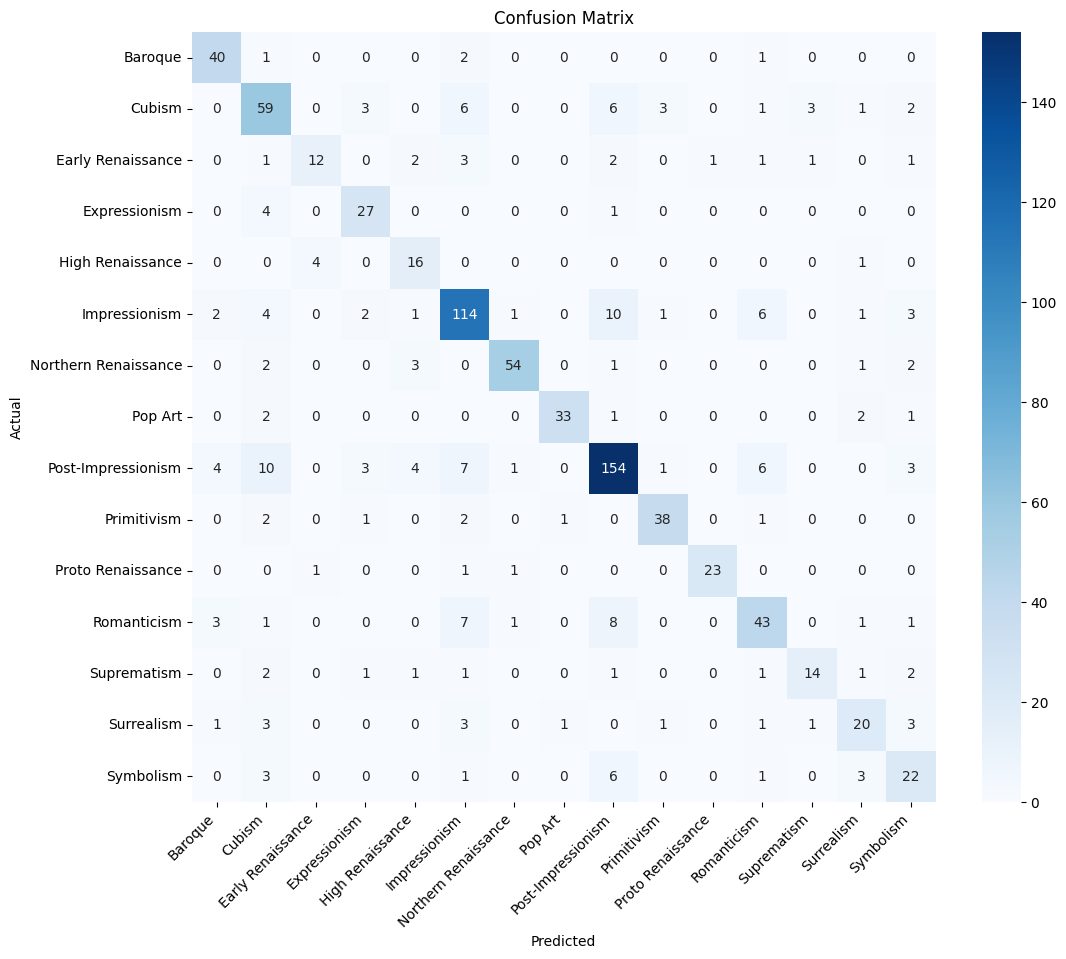

Overall ROC-AUC (Micro): 0.9606


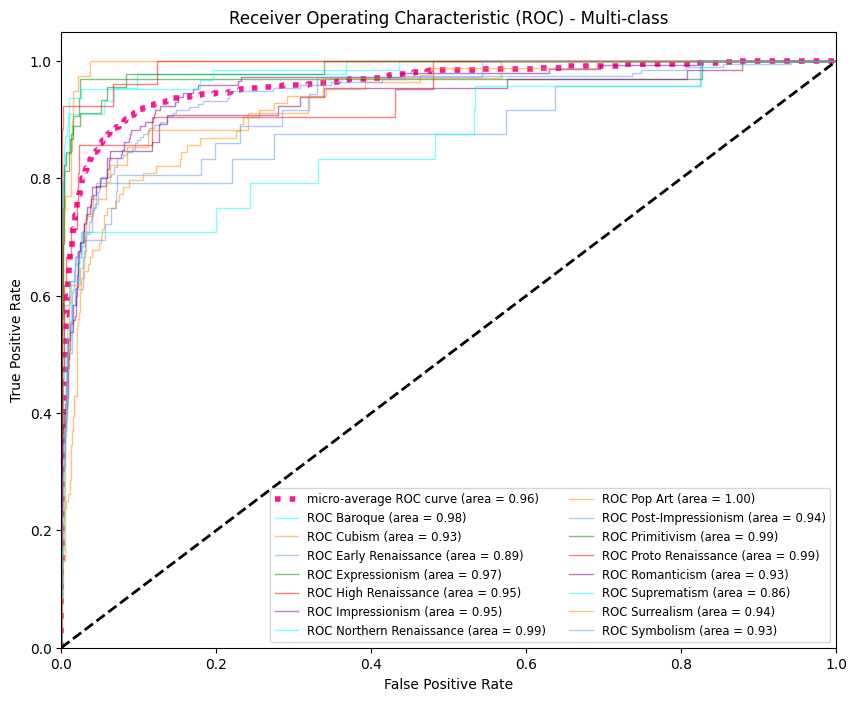

Overall PR-AUC (Micro): 0.7956


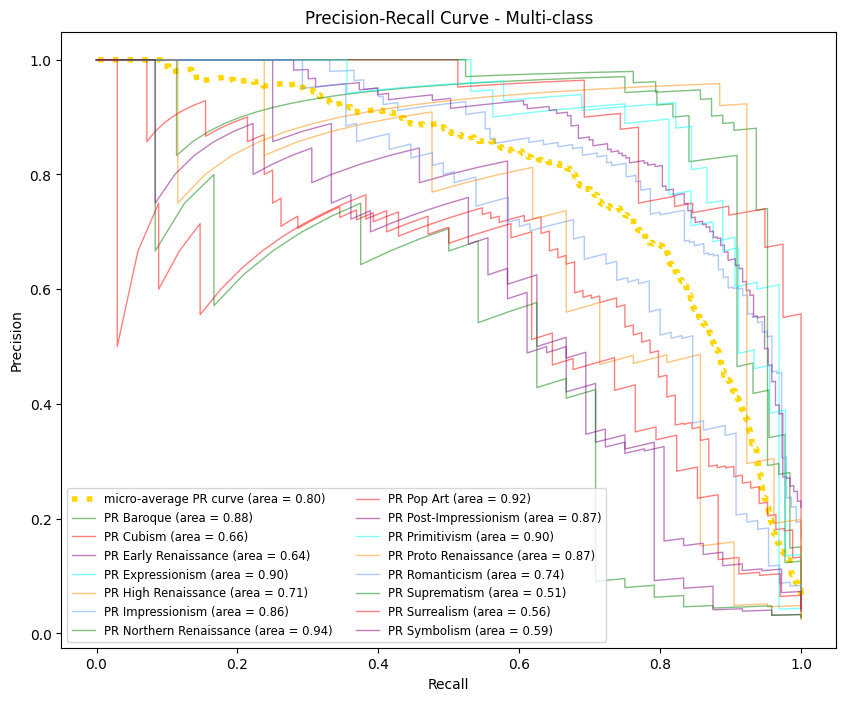

In [29]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import classification_report, accuracy_score

svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda', LDA(n_components=None)),
    ('svm', SVC(
        class_weight='balanced',
        random_state=42,
        probability=True,
        C = 10,
        gamma = 'scale',
        cache_size=5000          # Uses 1GB RAM for cache to speed up training
    ))
])
print("Starting Training Process")
svm_pipeline.fit(X_train, y_train)

# Evaluate
evaluate_model(svm_pipeline, X_test, y_test, classes)

# Training (Random Forest)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
--- Scalar Metrics ---
              precision    recall  f1-score   support

           0       0.48      0.93      0.64        44
           1       0.64      0.58      0.61        84
           2       0.78      0.58      0.67        24
           3       0.72      0.88      0.79        32
           4       0.57      0.62      0.59        21
           5       0.62      0.78      0.69       145
           6       0.68      0.95      0.79        63
           7       0.80      0.90      0.84        39
           8       0.75      0.67      0.70       193
           9       0.81      0.67      0.73        45
          10       0.70      0.88      0.78        26
          11       0.73      0.42      0.53        65
          12       0.60      0.38      0.46        24
          13       0.80      0.12      0.21        34
          14       0.68      0.36      0.47        36

    accuracy                           0.67       

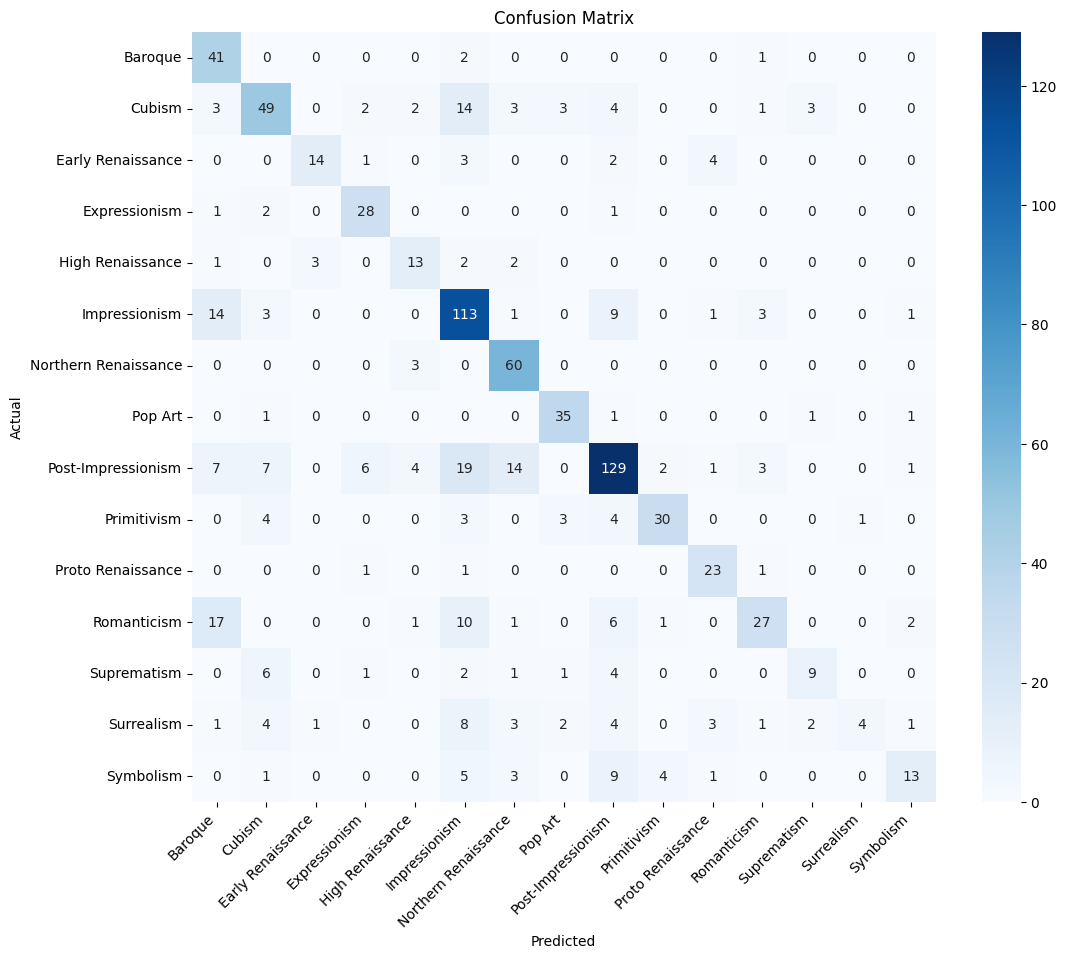

Overall ROC-AUC (Micro): 0.9546


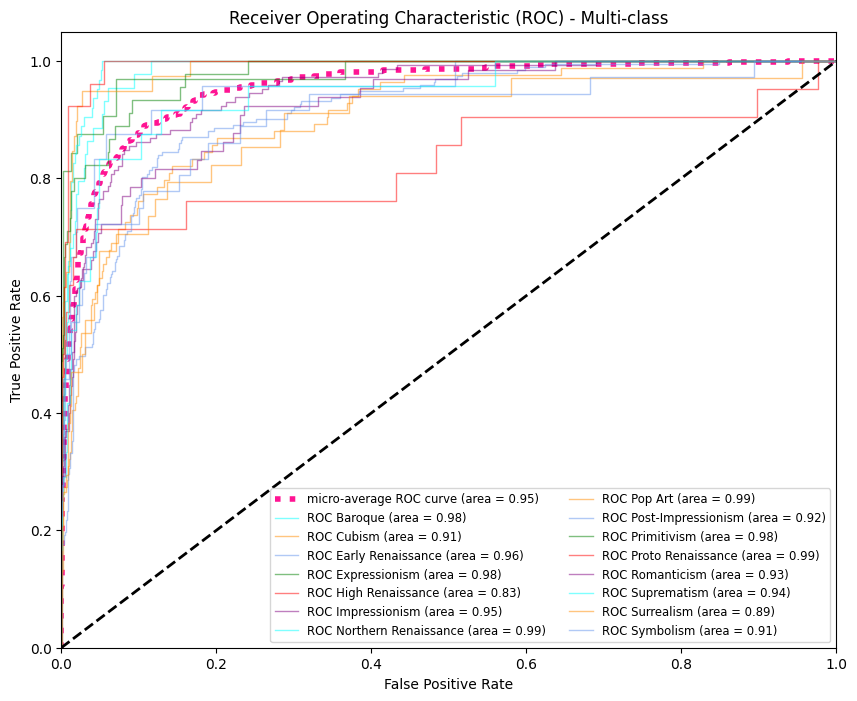

Overall PR-AUC (Micro): 0.7244


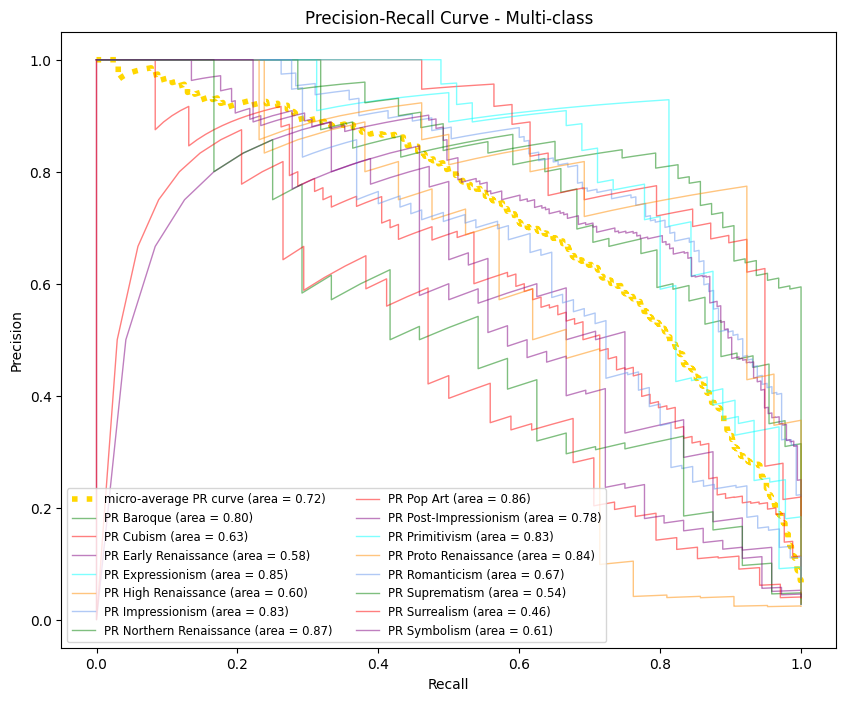

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=1000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])
param_dist_rf = {
        'rf__n_estimators': [200, 500],
        'rf__max_depth': [10, 20, 30, None],
        'rf__min_samples_leaf': [1, 2, 4]
}

random_rf = RandomizedSearchCV(rf_pipeline, param_distributions=param_dist_rf, 
                                   n_iter=10, cv=3, n_jobs=-1, verbose=1, random_state=42)
random_rf.fit(X_train, y_train)

# --- Evaluation ---
evaluate_model(random_rf.best_estimator_, X_test, y_test, classes)